In [2]:
from transformers import pipeline

In [3]:
pipeline = pipeline(task='sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/Users/bytedance/miniconda3/envs/rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [6]:
pipeline('jhhasa')

[{'label': 'POSITIVE', 'score': 0.533002495765686}]

$$ softmax(QK^T)V/sqrt(dim) $$

In [31]:
import math
import torch.nn.functional as F

def attention(q, k, v):
    d_k = q.size(-1)
    attn_scores =  F.softmax(torch.matmul(q,k.transpose(-2,-1)), dim=-1)
    return torch.matmul(attn_scores, v)

In [32]:
import torch

#(batch, n_seq, n_embedding)
q = torch.randn(2,3,4)
k = torch.randn(2,3,4)
v = torch.randn(2,3,4)

attention(q,k,v).shape

torch.Size([2, 3, 4])

In [33]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [34]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to('cuda')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [35]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [36]:
text = 'beijing is the capital of'
input_ids = tokenizer.encode(text, return_tensors='pt').to('cuda')
input_ids

tensor([[ 1350, 11030,   318,   262,  3139,   286]], device='cuda:0')

## greedy search by pytorch

In [37]:
len(model(input_ids)[1])

12

In [38]:
model(input_ids).logits

tensor([[[ -31.2955,  -30.7242,  -33.5247,  ...,  -38.5297,  -37.1183,
           -31.6377],
         [ -74.8156,  -71.7605,  -77.7048,  ...,  -81.8909,  -80.3852,
           -74.5409],
         [-108.7757, -106.9083, -112.4178,  ..., -115.2007, -112.8077,
          -110.7299],
         [-118.3764, -114.9017, -117.7331,  ..., -119.7403, -120.5365,
          -116.0456],
         [ -72.2195,  -72.3437,  -79.5916,  ...,  -83.7686,  -79.7855,
           -73.1781],
         [ -89.8919,  -88.1058,  -90.4214,  ...,  -95.1614,  -95.6007,
           -89.7220]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [39]:
outputs = model.generate(input_ids, max_length=20)
out_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
out_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"beijing is the capital of China's second largest economy, and has been a major source of economic"

## greedy search by self

In [40]:
!pip install networkx

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [77]:
import networkx as nx
import numpy as np
import torch.nn.functional as F
import torch

def get_log_prob(logits, token_id):
    # compute the softmax of the logits
    probabilities = F.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)

    # get the log probability of the token
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

def greedy_search(input_ids, node, length=5):
    if length==0:
        return input_ids
    print('input_ids', input_ids)
    outputs = model(input_ids)
    predictions = outputs.logits
    print('predictions', predictions.shape)
    # get the predicted next sub-word
    logits = predictions[0, -1, :]
    print('logits', logits.shape)
    token_id = torch.argmax(logits).unsqueeze(0) 
    print('token_id', token_id)

    # compute the score of the predicted token
    token_score = get_log_prob(logits, token_id)
    print('token_score', token_score)

    # add the predicted token to the list of input ids
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    # add node and edge to graph
    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f'_{length}'

    # Recursive call
    input_ids = greedy_search(new_input_ids, current_node, length-1)
    return input_ids

def greedy_tokens(input_ids):
    outputs = model(input_ids)
    predictions = outputs.logits
    logits = predictions[0, :, :]
    # print(logits)
    token_ids = torch.argmax(logits, dim=-1)
    print(token_ids)
    return tokenizer.decode(token_ids, skip_special_tokens=True)

In [79]:
# beijing| is| the| capital| of|
# ,,| a| only| of| China|
greedy_tokens(input_ids)

tensor([  11,   11,  257,  691,  286, 2807], device='cuda:0')


',, a only of China'

In [62]:
length = 5
beams = 1

graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

# start generating text
output_ids = greedy_search(input_ids, 0, length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_token=True)
output

input_ids tensor([[ 1350, 11030,   318,   262,  3139,   286]], device='cuda:0')
predictions torch.Size([1, 6, 50257])
logits torch.Size([50257])
token_id tensor([2807], device='cuda:0')
token_score -0.9834821224212646
input_ids tensor([[ 1350, 11030,   318,   262,  3139,   286,  2807]], device='cuda:0')
predictions torch.Size([1, 7, 50257])
logits torch.Size([50257])
token_id tensor([338], device='cuda:0')
token_score -0.9967012405395508
input_ids tensor([[ 1350, 11030,   318,   262,  3139,   286,  2807,   338]],
       device='cuda:0')
predictions torch.Size([1, 8, 50257])
logits torch.Size([50257])
token_id tensor([1218], device='cuda:0')
token_score -2.010037899017334
input_ids tensor([[ 1350, 11030,   318,   262,  3139,   286,  2807,   338,  1218]],
       device='cuda:0')
predictions torch.Size([1, 9, 50257])
logits torch.Size([50257])
token_id tensor([4387], device='cuda:0')
token_score -0.7930124998092651
input_ids tensor([[ 1350, 11030,   318,   262,  3139,   286,  2807,   338,

"beijing is the capital of China's second largest economy"

## beam search

In [88]:
!conda install pygraphviz -y

Channels:
 - defaults
 - conda-forge
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: - 

## Package Plan ##

  environment location: /home/samtang/miniconda3/envs/rl

  added / updated specs:
    - pygraphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.36.0             |       ha1a6a79_0         466 KB
    cairo-1.16.0               |       hb05425b_5         1.2 MB
    expat-2.6.4                |       h6a678d5_0         180 KB
    font-ttf-dejavu-sans-mono-2.37|       hd3eb1b0_0         335 KB
    font-ttf-inconsolata-2.001 |       hcb22688_0          83 KB
    font-ttf-source-code-pro-2.030|       hd3eb1b0_0         654 KB
    font-ttf-ubuntu-0.83       |       h8b1ccd4_0         1.5 MB
    fontconfig-2.14.1          |       h55d465d_3         281 KB
    fonts-anaconda-1           |       h8fa9717_0           3 KB
    fonts-cond

In [91]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')

    # Create positions for each node
    pos = nx.nx_agraph.graphviz_layout(graph, prog='dot')

    # Normalize the colors along the range of token scores
    if score=='token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score=='sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]

    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)

    # Draw the nodes
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4, node_color=scores, cmap=cmap) 
        
    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Draw the labels
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencescore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')

    plt.show()
    

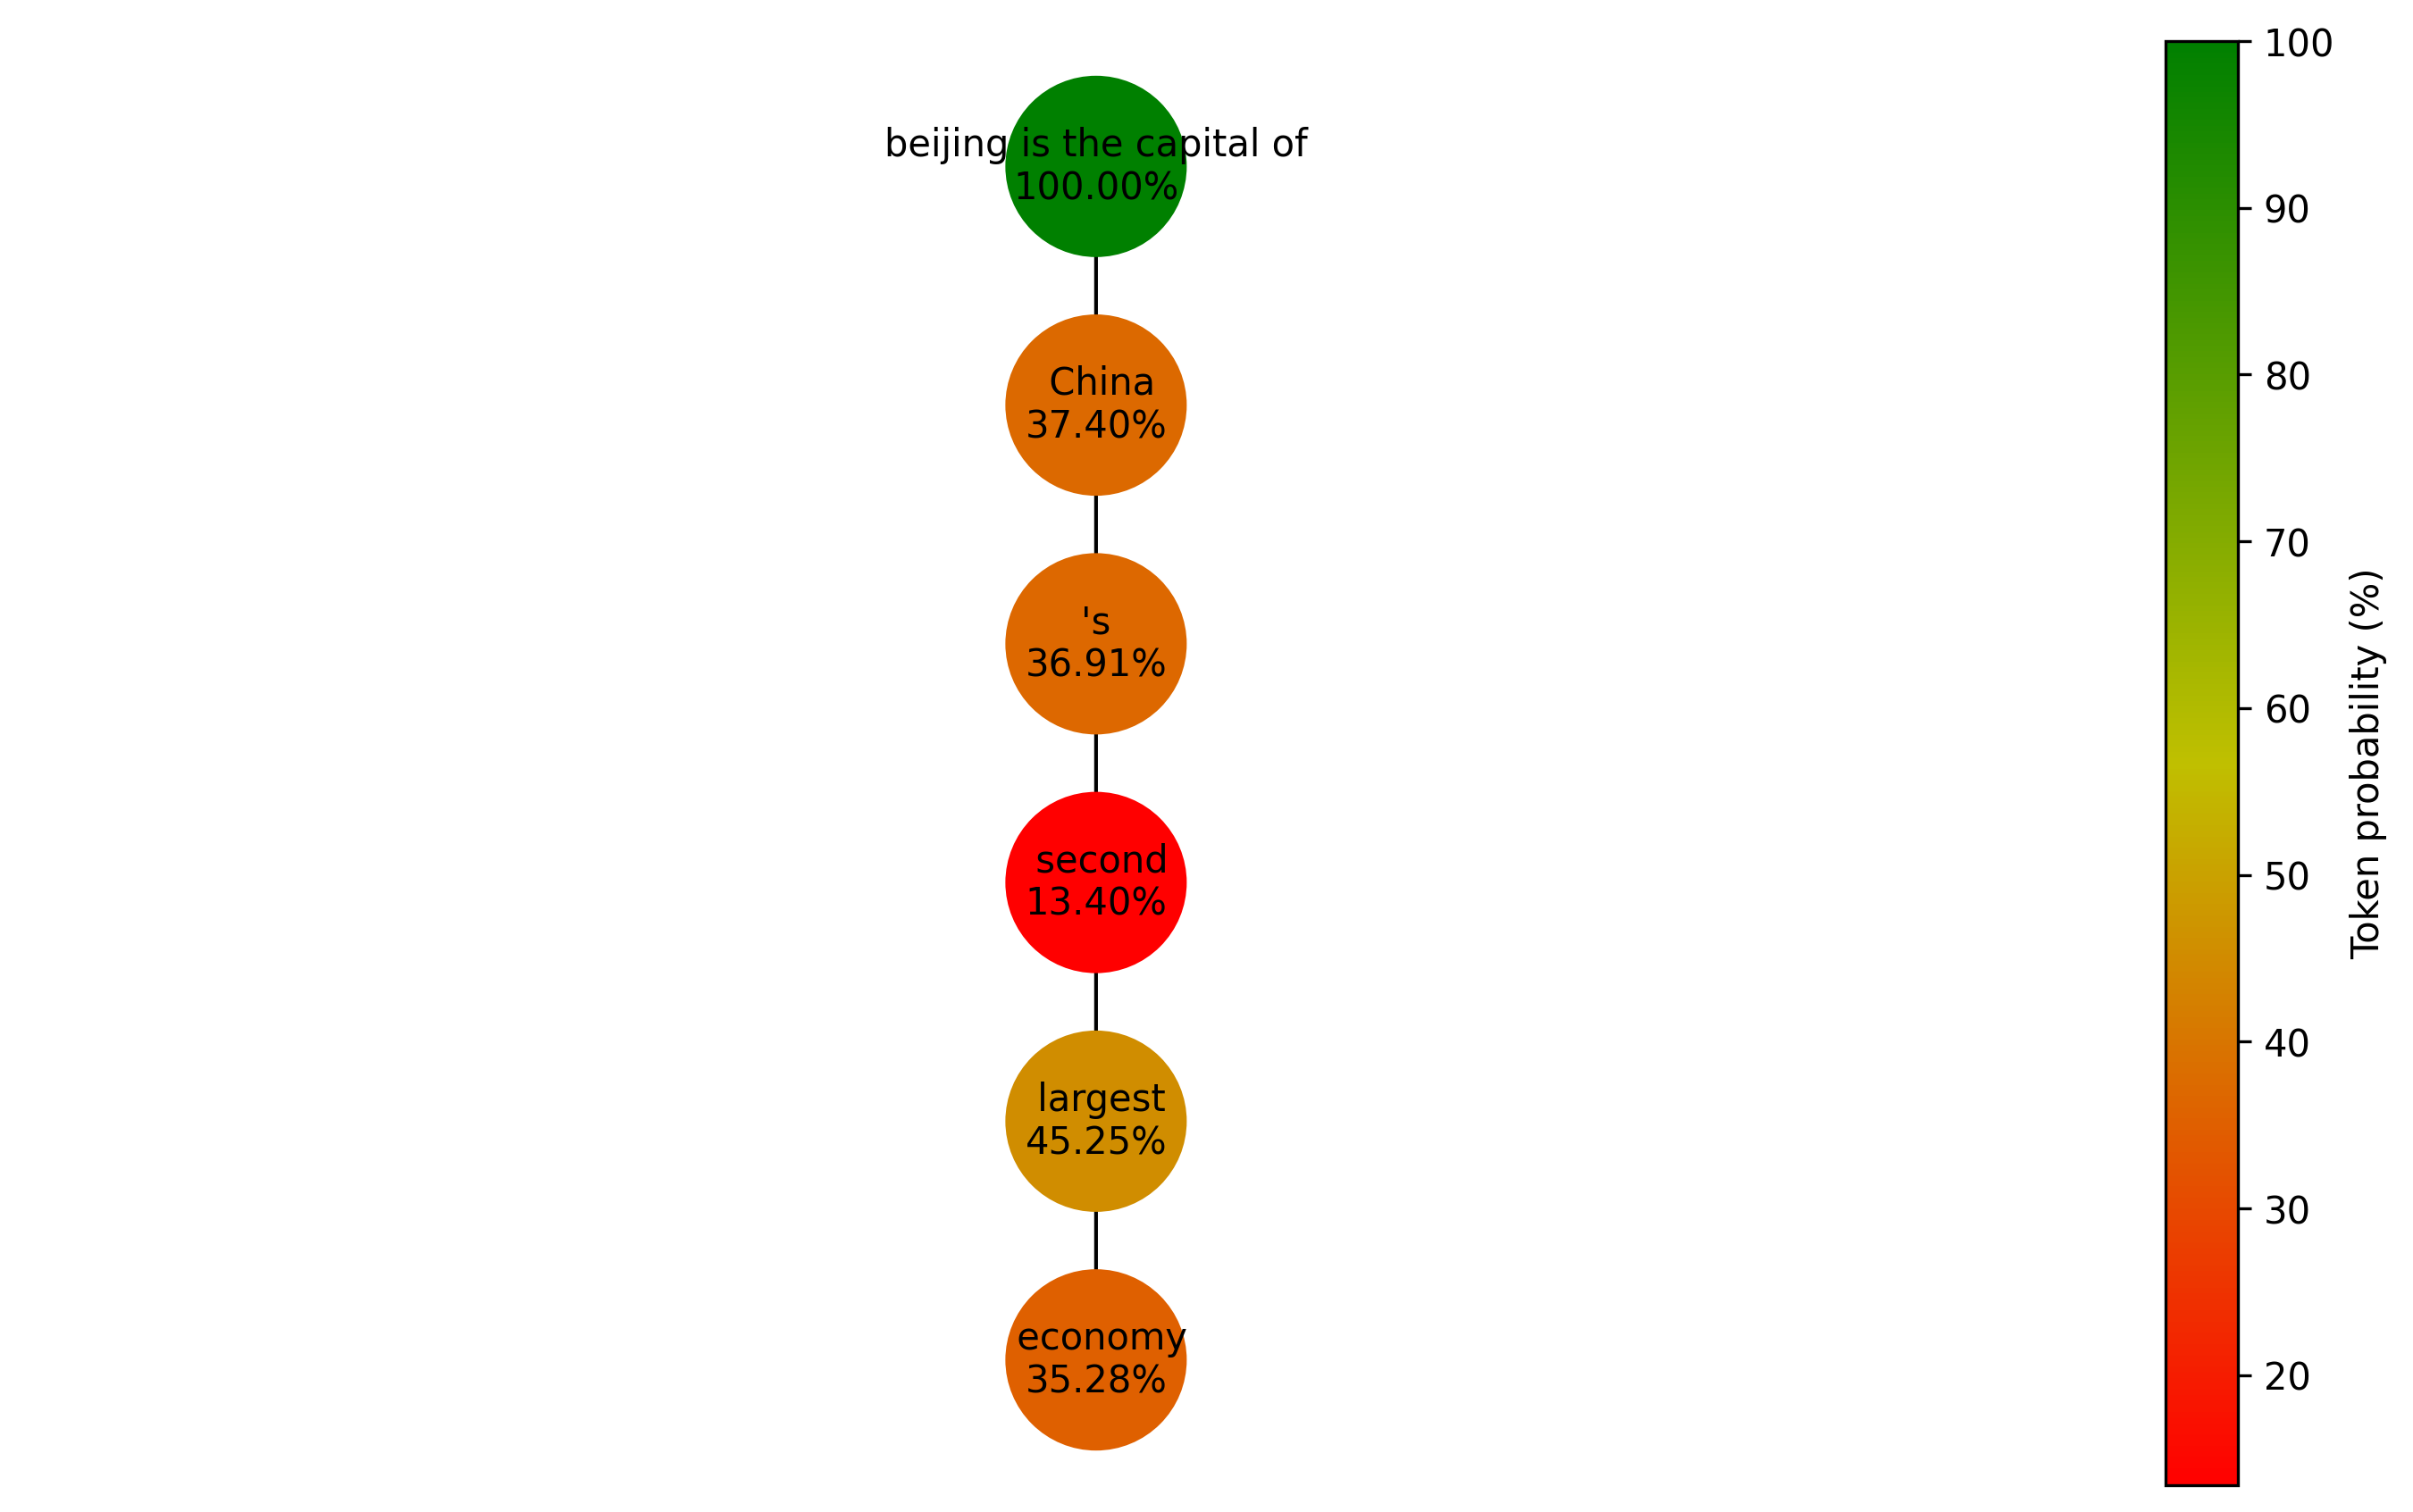

In [92]:
# plot graph

plot_graph(graph, length, 1.5, 'token')